In [ ]:
!pip install pandas numpy scikit-learn lifelines scipy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 6.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=cebe3acf20de7023a11fe69f1561b63f75a74a67f55352c294b42c49395f4943
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import cupy as cp
from scipy.special import expit  # Sigmoid function for normalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
compas_df = pd.read_csv('/content/drive/My Drive/compas-scores-two-years.csv')

In [ ]:
# Preprocess the dataset
compas_df = compas_df.dropna(subset=['c_charge_degree', 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'two_year_recid'])
compas_df = pd.get_dummies(compas_df, columns=['c_charge_degree', 'race'], drop_first=True)

# Feature selection and scaling
features = ['age', 'juv_fel_count', 'juv_misd_count', 'priors_count'] + [col for col in compas_df.columns if 'c_charge_degree_' in col or 'race_' in col]
X = compas_df[features]
y = compas_df['two_year_recid']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Survival times and event indicators
T = compas_df['decile_score']
E = compas_df['two_year_recid']


In [ ]:
# Define FNDCG Metric
def compute_similarity_matrix_gpu(X):
    X_gpu = cp.asarray(X)
    distances = cp.exp(-cp.linalg.norm(X_gpu[:, None] - X_gpu, axis=2))
    return cp.asnumpy(distances)

def compute_FNDCG(SimD_prime, SimD, k=10):
    def DCG_at_k(similarities, k):
        return np.sum(similarities[:k] / np.log2(np.arange(2, k + 2)))

    N = SimD_prime.shape[0]
    FNDCG_values = []

    for i in range(N):
        sorted_indices_prime = np.argsort(-SimD_prime[i])
        sorted_indices = np.argsort(-SimD[i])

        DCG_prime = DCG_at_k(SimD_prime[i, sorted_indices_prime], k)
        DCG = DCG_at_k(SimD_prime[i, sorted_indices], k)

        FNDCG_values.append(DCG / DCG_prime)

    return np.mean(FNDCG_values)

# Define Group Fairness Metric (Disparate Impact)
def disparate_impact(predictions, sensitive_features, epsilon=1e-10):
    group_1_rate = np.mean(predictions[sensitive_features == 0])
    group_2_rate = np.mean(predictions[sensitive_features == 1])
    print(f'Group 1 Rate: {group_1_rate}, Group 2 Rate: {group_2_rate}')
    return group_1_rate / (group_2_rate + epsilon)

In [ ]:
# Implement Cox Proportional Hazards Model (CPH)
cox_model = CoxPHFitter()
cox_model.fit(pd.DataFrame(X_scaled, columns=features).assign(T=T, E=E), 'T', event_col='E')

# Define the fair Cox loss function with mini-batch processing
def fair_cox_loss_function(beta, X, T, E, SimD_prime, k=10, gamma=1.0, batch_size=512):
    n_batches = int(np.ceil(X.shape[0] / batch_size))
    total_loss = 0.0

    for i in range(n_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, X.shape[0])

        X_batch = X[start:end]
        T_batch = T[start:end]
        E_batch = E[start:end]
        SimD_prime_batch = SimD_prime[start:end, start:end]

        # Partial likelihood for Cox model
        risk_scores = X_batch.dot(beta)
        exp_risk_scores = np.exp(risk_scores)
        partial_likelihood = np.sum(risk_scores[E_batch == 1]) - np.sum(np.log(np.cumsum(exp_risk_scores[::-1])[::-1][E_batch == 1]))

        # Compute SimD based on current risk scores
        SimD = compute_similarity_matrix_gpu(risk_scores.reshape(-1, 1))

        # Compute FNDCG
        FNDCG = compute_FNDCG(SimD_prime_batch, SimD, k)

        # Combined loss function
        batch_loss = -partial_likelihood + gamma * (1 - FNDCG)
        total_loss += batch_loss

    return total_loss / n_batches

# Define the fair ind group Cox loss function with mini-batch processing
def fair_cox_group_loss_function(beta, X, T, E, SimD_prime, sensitive_features, k=10, gamma=1.0, delta=1.0, batch_size=512):
    n_batches = int(np.ceil(X.shape[0] / batch_size))
    total_loss = 0.0

    for i in range(n_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, X.shape[0])

        X_batch = X[start:end]
        T_batch = T[start:end]
        E_batch = E[start:end]
        SimD_prime_batch = SimD_prime[start:end, start:end]
        sensitive_features_batch = sensitive_features[start:end]

        # Partial likelihood for Cox model
        risk_scores = X_batch.dot(beta)
        exp_risk_scores = np.exp(risk_scores)
        partial_likelihood = np.sum(risk_scores[E_batch == 1]) - np.sum(np.log(np.cumsum(exp_risk_scores[::-1])[::-1][E_batch == 1]))

        # Compute SimD based on current risk scores
        SimD = compute_similarity_matrix_gpu(risk_scores.reshape(-1, 1))

        # Compute FNDCG
        FNDCG = compute_FNDCG(SimD_prime_batch, SimD, k)

        # Compute group fairness (disparate impact)
        group_fairness = disparate_impact(risk_scores > np.median(risk_scores), sensitive_features_batch)
        group_fairness = expit(group_fairness) # Normalize with a sigmoid function


        # Combined loss function
        batch_loss = -partial_likelihood + (gamma * (1 - FNDCG) + delta * (1 - group_fairness))* (1/(2*(gamma + delta)))
        total_loss += batch_loss

    return total_loss / n_batches

In [ ]:
# Callback function for logging
class CallbackLogger:
    def __init__(self, X, T, E, SimD_prime, k, gamma, batch_size=512):
        self.X = X
        self.T = T
        self.E = E
        self.SimD_prime = SimD_prime
        self.k = k
        self.gamma = gamma
        self.batch_size = batch_size
        self.iteration = 0

    def __call__(self, beta):
        self.iteration += 1
        if self.iteration % 10 == 0:  # Print every 10 iterations
            loss = fair_cox_loss_function(beta, self.X, self.T, self.E, self.SimD_prime, self.k, self.gamma, self.batch_size)
            risk_scores = self.X.dot(beta)
            c_index = concordance_index(self.T, -risk_scores, self.E)
            SimD = compute_similarity_matrix_gpu(risk_scores.reshape(-1, 1))
            FNDCG = compute_FNDCG(self.SimD_prime, SimD, self.k)
            print(f"Iteration {self.iteration}: Loss = {loss}, C-index = {c_index}, FNDCG@{self.k} = {FNDCG}")


# Callback function for logging
class CallbackLogger1:
    def __init__(self, X, T, E, SimD_prime, sensitive_features, k, gamma, delta, batch_size=512):
        self.X = X
        self.T = T
        self.E = E
        self.SimD_prime = SimD_prime
        self.sensitive_features = sensitive_features
        self.k = k
        self.gamma = gamma
        self.delta = delta
        self.batch_size = batch_size
        self.iteration = 0

    def __call__(self, beta):
        self.iteration += 1
        if self.iteration % 10 == 0:  # Print every 10 iterations
            #loss = fair_cox_group_loss_function(beta, self.X, self.T, self.E, self.SimD_prime, self.sensitive_features, self.k, self.gamma, self.delta, self.batch_size)

            risk_scores = self.X.dot(beta)
            c_index = concordance_index(self.T, -risk_scores, self.E)
            SimD = compute_similarity_matrix_gpu(risk_scores.reshape(-1, 1))
            FNDCG = compute_FNDCG(self.SimD_prime, SimD, self.k)
            group_fairness = disparate_impact(risk_scores > np.median(risk_scores), self.sensitive_features)
            print(f"Iteration {self.iteration}: Loss = {loss}, C-index = {c_index}, FNDCG@{self.k} = {FNDCG}, Disparate Impact = {group_fairness}")


In [ ]:
# Initial beta
initial_beta = np.zeros(X_scaled.shape[1])

# Similarity matrix in input space
SimD_prime = compute_similarity_matrix_gpu(X_scaled)

# Sensitive features (e.g., race)
# Combine all race columns into one binary column for simplicity
sensitive_features = compas_df[[col for col in compas_df.columns if 'race_' in col]].values.argmax(axis=1)

# Callback logger
logger = CallbackLogger1(X_scaled, T, E, SimD_prime, sensitive_features, k=10, gamma=1.0, delta=1.0)

# Minimize the combined loss function with logging
result = minimize(fair_cox_group_loss_function, initial_beta, args=(X_scaled, T, E, SimD_prime, sensitive_features, 10, 1.0, 0.01, 512), method='L-BFGS-B', callback=logger)
beta_hat = result.x

# Train and Evaluate the Model
# Predict risk scores and evaluate
risk_scores = X_scaled.dot(beta_hat)
c_index = concordance_index(T, -risk_scores, E)
print(f'Final Concordance Index: {c_index}')

# Compute the final SimD and FNDCG
SimD_final = compute_similarity_matrix_gpu(risk_scores.reshape(-1, 1))
final_FNDCG = compute_FNDCG(SimD_prime, SimD_final, 10)
print(f'Final FNDCG: {final_FNDCG}')

# Compute group fairness
final_group_fairness = disparate_impact(risk_scores > np.median(risk_scores), sensitive_features)
print(f'Final Group Fairness (Disparate Impact): {final_group_fairness}')

Final Concordance Index: 0.5409086386413985
Final FNDCG: 0.7703738787498525
Final Group Fairness (Disparate Impact): 0.5196803703777584


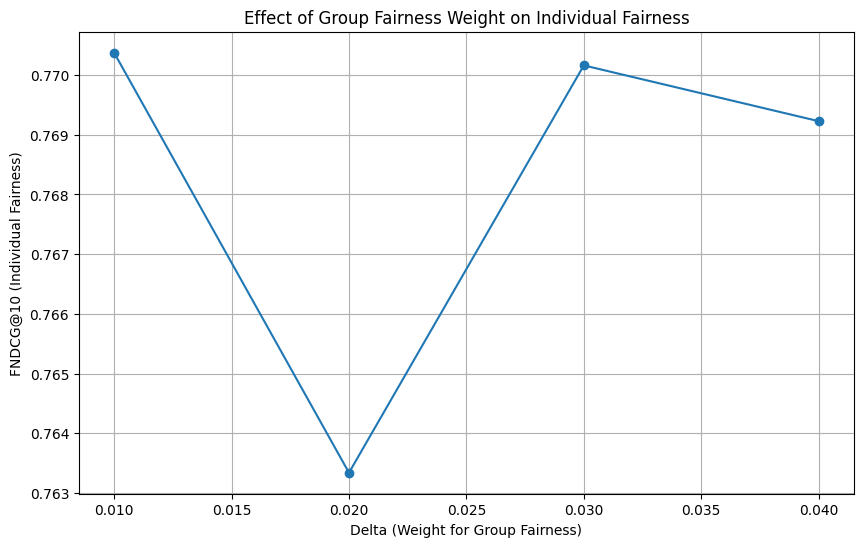

In [ ]:
# Define hyperparameters
gamma = 1.0  # Weight for individual fairness
delta_values = [0.01, 0.02, 0.03, 0.04]  # Different weights for group fairness

# Store results
results = []

for delta in delta_values:
    # Initialize beta
    initial_beta = np.zeros(X_scaled.shape[1])

    # Callback logger
    logger = CallbackLogger(X_scaled, T, E, SimD_prime, sensitive_features, k=10, gamma=gamma, delta=delta)

    # Minimize the combined loss function with logging
    result = minimize(fair_cox_group_loss_function, initial_beta, args=(X_scaled, T, E, SimD_prime, sensitive_features, 10, gamma, delta, 512), method='L-BFGS-B', callback=logger)
    beta_hat = result.x

    # Predict risk scores and evaluate
    risk_scores = X_scaled.dot(beta_hat)
    c_index = concordance_index(T, -risk_scores, E)
    SimD_final = compute_similarity_matrix_gpu(risk_scores.reshape(-1, 1))
    final_FNDCG = compute_FNDCG(SimD_prime, SimD_final, 10)
    final_group_fairness = disparate_impact(risk_scores > np.median(risk_scores), sensitive_features)

    # Store the results
    results.append((delta, final_FNDCG))

# Convert results to DataFrame for plotting
results_df = pd.DataFrame(results, columns=['delta', 'FNDCG'])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['delta'], results_df['FNDCG'], marker='o', linestyle='-')
plt.xlabel('Delta (Weight for Group Fairness)')
plt.ylabel('FNDCG@10 (Individual Fairness)')
plt.title('Effect of Group Fairness Weight on Individual Fairness')
plt.grid(True)
plt.show()

Iteration 20: Loss = 1130.7291137396753, C-index = 0.5396531297175848, FNDCG@10 = 0.7685656096407304
Iteration 30: Loss = 1130.6833784292335, C-index = 0.49055020934371635, FNDCG@10 = 0.7043567240637615


<ipython-input-24-4692cfe86b9a>:21: RuntimeWarning: overflow encountered in exp
  exp_risk_scores = np.exp(risk_scores)
<ipython-input-24-4692cfe86b9a>:22: RuntimeWarning: divide by zero encountered in log
  partial_likelihood = np.sum(risk_scores[E_batch == 1]) - np.sum(np.log(np.cumsum(exp_risk_scores[::-1])[::-1][E_batch == 1]))
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Iteration 40: Loss = 1130.7339043026793, C-index = 0.5405163938259473, FNDCG@10 = 0.6807851368623096
Iteration 50: Loss = 1130.7076661333724, C-index = 0.5322155603898057, FNDCG@10 = 0.789413212675232
Iteration 60: Loss = 1130.5095289346839, C-index = 0.46936399808901363, FNDCG@10 = 0.8801772877007304
Iteration 70: Loss = 1130.7283705192408, C-index = 0.5397413983641601, FNDCG@10 = 0.7726085084941736
Iteration 80: Loss = 1130.7333726265642, C-index = 0.5405112941008224, FNDCG@10 = 0.6818929011554429
Iteration 90: Loss = 1130.49410647618, C-index = 0.5103764215619416, FNDCG@10 = 0.7635130093236341
Iteration 100: Loss = 1130.7332493622584, C-index = 0.5404077805312677, FNDCG@10 = 0.6799243609468505


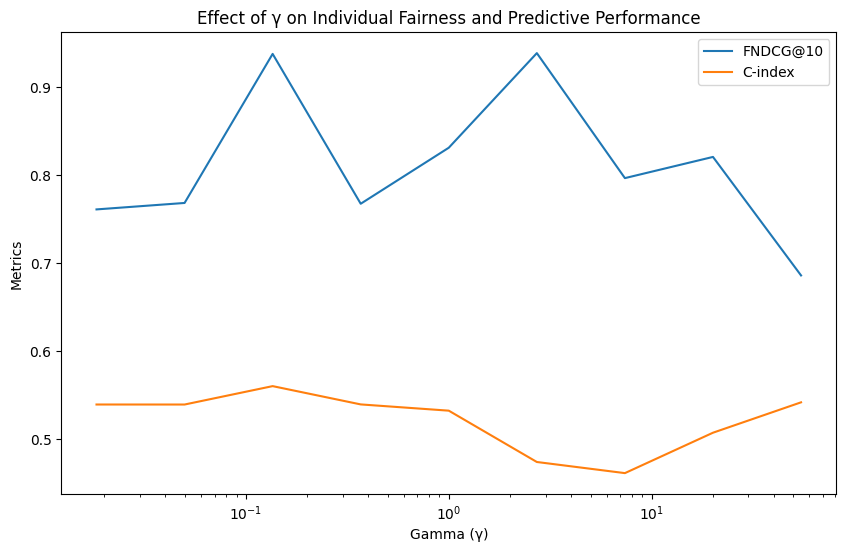

In [ ]:
# Plotting the effect of γ on individual fairness and predictive performance
gamma_values = np.exp(np.arange(-4, 5))
fndcg_values = []
cindex_values = []

for gamma in gamma_values:
    result = minimize(fair_cox_loss_function, initial_beta, args=(X_scaled, T, E, SimD_prime, 10, gamma, 512), method='L-BFGS-B', callback=logger)
    beta_hat = result.x
    risk_scores = X_scaled.dot(beta_hat)
    c_index = concordance_index(T, -risk_scores, E)
    SimD_final = compute_similarity_matrix_gpu(risk_scores.reshape(-1, 1))
    final_FNDCG = compute_FNDCG(SimD_prime, SimD_final, 10)
    fndcg_values.append(final_FNDCG)
    cindex_values.append(c_index)

plt.figure(figsize=(10, 6))
plt.plot(gamma_values, fndcg_values, label='FNDCG@10')
plt.plot(gamma_values, cindex_values, label='C-index')
plt.xscale('log')
plt.xlabel('Gamma (γ)')
plt.ylabel('Metrics')
plt.legend()
plt.title('Effect of γ on Individual Fairness and Predictive Performance')
plt.show()

In [ ]:
# Plotting the effect of k on individual fairness and predictive performance
k_values = [4, 7, 10, 15, 20, 30, 50]
fndcg_values = []
cindex_values = []

for k in k_values:
    result = minimize(fair_cox_loss_function, initial_beta, args=(X_scaled, T, E, SimD_prime, k, 1.0, 512), method='L-BFGS-B', callback=logger)
    risk_scores = X_scaled.dot(beta_hat)
    c_index = concordance_index(T, -risk_scores, E)
    SimD_final = compute_similarity_matrix_gpu(risk_scores.reshape(-1, 1))
    final_FNDCG = compute_FNDCG(SimD_prime, SimD_final, k)
    fndcg_values.append(final_FNDCG)
    cindex_values.append(c_index)

plt.figure(figsize=(10, 6))
plt.plot(k_values, fndcg_values, label='FNDCG@10')
plt.plot(k_values, cindex_values, label='C-index')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Metrics')
plt.legend()
plt.title('Effect of k on Individual Fairness and Predictive Performance')
plt.show()